In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import random
import os

# YOU NEED TO GO TO THE paths.py FILE AND PUT YOUR FOLDER OF IMAGES in the CAR_IMAGES_DIR variable
from paths import CAR_IMAGES_DIR  


INDIVIDUAL_IMG_PATHS = [CAR_IMAGES_DIR / image_name for image_name 
                        in os.listdir(CAR_IMAGES_DIR)]

In [2]:
#FUNCTIONS FOR PLOTTING VARIOS RESULTS
def plot_binary_methods():
    plt.figure(figsize=(15, 10))   # (width, height)
    methods = ['original', 'simple', 'adaptive', 'otsu', 'Gaus_otsu']
    
    for i in range(len(methods) * 3):
        pos = i % len(methods)
        if (pos == 0):
            image_path = random.choice(INDIVIDUAL_IMG_PATHS)
            
        image = binary_methods(image_path, method=methods[pos])
        plt.subplot(3, len(methods), i+1)
        plt.imshow(image, 'gray')
        plt.title(methods[pos])
        plt.xticks([]),plt.yticks([])
    
    plt.show()

def plot_mhorp_methods():
    plt.figure(figsize=(15, 10))   # (width, height)
    methods = ['original', 'dilation', 'erosion', 'opening', 'closing']
    
    for i in range(len(methods) * 3):
        pos = i % len(methods)
        if (pos == 0):
            image_path = random.choice(INDIVIDUAL_IMG_PATHS)
        
        binary_image = binary_methods(image_path, method = 'simple')
        output = mhorp_operations(binary_image, method = methods[pos], image_path=image_path)
        plt.subplot(3, len(methods), i+1)
        plt.imshow(output, 'gray')
        plt.title(methods[pos])
        plt.xticks([]),plt.yticks([])
    
    plt.show()

In [3]:
#Function for appyling the binarization methods
def binary_methods(image_gray, method = 'simple'):
    #if method == 'original':
    #return image_rgb
    if method == 'simple':
        binary__image = cv.threshold(image_gray, 127, 255, 0)[1]

    elif method == 'adaptive':
        binary__image = cv.adaptiveThreshold(image_gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)

    elif method == 'otsu':
        _, binary__image = cv.threshold(image_gray, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

    return binary__image

#Function for applying the mhorpological operations
def mhorp_operations(binary_image, method = 'dilation', image_path = None):
    kernel = np.ones((4,10),np.uint8)
    
    if method == 'original':
        image = cv.imread(str(image_path))
        image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        return image_rgb
    
    if method == 'dilation':
        result = cv.dilate(binary_image, kernel, iterations = 1)

    elif method == 'erosion':
        result = cv.erode(binary_image, kernel, iterations = 1)

    elif method == 'opening':
        result = cv.morphologyEx(binary_image, cv.MORPH_OPEN, kernel)

    elif method == 'closing':
        result = cv.morphologyEx(binary_image, cv.MORPH_CLOSE, kernel)
        result = cv.morphologyEx(result, cv.MORPH_CLOSE, kernel)

    return result

# FUNCTION USED TO PREPROCESS A GIVEN IMAGE
def preprocess_image(image_path):
    #Open the image, and pass it from BGR to RGB
    image = cv.imread(image_path)
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    #Pass the image to gray scale. Apply also gaussian blur to reduce noise in the image
    image_gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)
    image_gray = cv.GaussianBlur(image_gray, (5, 5), 0)

    #Binarization doing one of the possible methods
    binary_image = binary_methods(image_gray, method='otsu')

    #Apply Mhorpological operations to the image using one of the possbile methods
    mhorp_image = mhorp_operations(binary_image, method = 'closing') 

    return mhorp_image  

# FUNCTION USED TO PREPROCESS A GIVEN IMAGE
def hsv_preprocess_image(image_path):
    #Open the image, and pass it from BGR to RGB
    image = cv.imread(image_path)
    image_hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    saturation = cv.split(image_hsv)[1]
    #Pass the image to gray scale. Apply also gaussian blur to reduce noise in the image
    #image_gray = cv.GaussianBlur(saturtion, (3, 3), 0)

    #Binarization doing one of the possible methods
    binary_image = binary_methods(saturation, method='simple')

    #Apply Mhorpological operations to the image using one of the possbile methods
    mhorp_image = mhorp_operations(binary_image, method = 'opening') 

    return mhorp_image  

In [2]:
import cv2
import numpy as np
import imutils
import easyocr

def preprocess_image(img_path):
    """Preprocess the image and return required intermediates."""
    # Read the image
    img = cv2.imread(img_path)
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Noise reduction using bilateral filter
    bfilter = cv2.bilateralFilter(gray, 11, 17, 17)
    # Edge detection using Canny

    edged = cv2.Canny(bfilter, 30, 200)

    return img, gray, edged


def find_license_plate_contour(edged):
    """Find and return the contour of the license plate."""
    # Find contours in the edge-detected image
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)
    # Sort contours based on area and keep the top 10
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    # Try finding a contour that resembles a license plate (4 corners)
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 10, True)
        if len(approx) == 4:
            return approx    
    return None

def extract_text_from_plate(img, gray, location):
    """Extract text from the detected license plate and annotate the original image."""
    mask = np.zeros(gray.shape, np.uint8)
    cv2.drawContours(mask, [location], 0, 255, -1)
    cv2.bitwise_and(img, img, mask=mask)
    (x, y) = np.where(mask==255)
    (x1, y1) = (np.min(x), np.min(y))
    (x2, y2) = (np.max(x), np.max(y))
    cropped_image = gray[x1:x2+1, y1:y2+1]

    reader = easyocr.Reader(['en'])
    result = reader.readtext(cropped_image)
    if (len(result) == 0):
        text = ""
    else:
        text = result[0][-2].upper()

    # Annotate the original image
    font = cv2.FONT_HERSHEY_SIMPLEX
    res = cv2.putText(img, text=text, org=(location[0][0][0], location[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
    res = cv2.rectangle(img, tuple(location[0][0]), tuple(location[2][0]), (0,255,0),3)
    return res

# Main method to process the image and visualize the results
def method1_contour_approximation(img_path):
    img, gray, edged = preprocess_image(img_path)
    location = find_license_plate_contour(edged)
    if location is None:
        print("Sorry, license plate not detected.")
        return
    result_img = extract_text_from_plate(img, gray, location)
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.show()

In [3]:
def find_license_plate_aspect_ratio(edged):
    """Find and return the contour of the license plate."""
    # Find contours in the edge-detected image
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)

    good_contours = []
    height, width = edged.shape
    # Calculating buffer in terms of pixels
    border_buffer_x = width * 0.1
    border_buffer_y = height * 0.1
    
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Check if the contour is inside the buffered region
        if (x > border_buffer_x) and (x + w < width - border_buffer_x) and \
           (y > border_buffer_y) and (y + h < height - border_buffer_y):
            #aspect_ratio = float(w) / h
            #if 1 < aspect_ratio:
            good_contours.append(contour)

    return None if len(contours) == 0 else good_contours

# Main method to process the image and visualize the results
def method_3(img_path):
    _, _, edged = preprocess_image(img_path)
    locations = find_license_plate_aspect_ratio(edged)
    if locations is None:
        print("Sorry, license plate not detected.")
        return
    return (locations), edged # Returns the contours that SVM needs to c

In [4]:
loc, img = method_3(str(INDIVIDUAL_IMG_PATHS[9]))

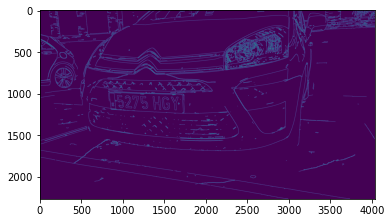

In [5]:
plt.imshow(img)

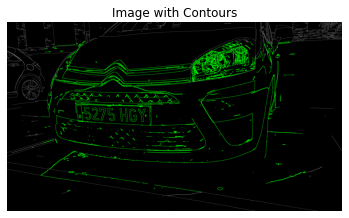

In [6]:
image_with_contours = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Ensure it's a BGR image

# Draw the contours on the image
cv2.drawContours(image_with_contours, loc, -1, (0, 255, 0), 2)

# Check if any contours were found
if loc:
    # Convert the image to RGB format (for plotting with matplotlib)
    image_with_contours_rgb = cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB)

    # Plot the image with contours using matplotlib
    plt.imshow(image_with_contours_rgb)
    plt.axis('off')
    plt.title('Image with Contours')
    plt.show()
else:
    print("No contours found.")

